# Описание проекта

Нужно решить, где бурить новую скважину в добывающей компании «ГлавРосГосНефть».     
Шаги для выбора локации обычно такие:
1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.
   
Предоставлены пробы нефти в трёх регионах. 
Характеристики для каждой скважины в регионе уже известны. 
Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание данных**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).
  
**Условия задачи:**
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).    
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.    
Бюджет на разработку скважин в регионе — 10 млрд рублей.    
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.    
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.    
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.    

## 1. Подготовка данных

### 1.1. Изучение общей информации о датасетах

In [1]:
!pip install --upgrade numpy -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [2]:
!pip install --upgrade scikit-learn -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [3]:
!pip install phik -q

In [4]:
!pip install --upgrade seaborn matplotlib -q

In [5]:
pip install --upgrade matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install --upgrade pandas -q

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import phik

from matplotlib.pyplot import rcParams, rcParamsDefault
from matplotlib import transforms
from scipy import stats as st
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)

from sklearn.compose import make_column_transformer

from sklearn.preprocessing import (
    StandardScaler
)

from sklearn.pipeline import make_pipeline

from itertools import combinations

In [9]:
# настроим параметры графиков
rcParams['figure.figsize'] = 7,4
%config InlineBackend.figure_format = 'svg'
factor = 0.8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

In [10]:
# Создадим функцию для получения первичной информации по датасету.
def get_data_info(data):
    display(data.sample(3))
    display(data.info())
    display(data.describe(include='all'))
    display('Количество явных дубликатов:', data.duplicated().sum())

In [11]:
# функция для загрузки данных из локального файла или URL.
def load_data(local_path, url):
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path)
            print('Данные успешно загружены из локального файла.')
            return data
        else:
            print('Локальный файл не найден, загрузка с URL...')
            raise FileNotFoundError
    except Exception as e:
        print('Ошибка при загрузке данных из локального файла:', e)
    
    # Попытка загрузки из URL
    try:
        data = pd.read_csv(url)
        print('Данные успешно загружены из URL.')
        return data
    except Exception as e:
        print('Ошибка при загрузке данных из URL:', e)
        return None

In [12]:
data_1 = load_data('/Users/gulnaravolodina/Downloads/geo_data_0.csv', 
                 'https://code.s3.yandex.net/datasets/geo_data_0.csv')

Локальный файл не найден, загрузка с URL...
Ошибка при загрузке данных из локального файла: 
Данные успешно загружены из URL.


In [13]:
data_2 = load_data('/Users/gulnaravolodina/Downloads/geo_data_1.csv', 
                 'https://code.s3.yandex.net/datasets/geo_data_1.csv')

Локальный файл не найден, загрузка с URL...
Ошибка при загрузке данных из локального файла: 
Данные успешно загружены из URL.


In [14]:
data_3 = load_data('/Users/gulnaravolodina/Downloads/geo_data_2.csv', 
                 'https://code.s3.yandex.net/datasets/geo_data_2.csv')

Локальный файл не найден, загрузка с URL...
Ошибка при загрузке данных из локального файла: 
Данные успешно загружены из URL.


In [15]:
get_data_info(data_1)

,id,f0,f1,f2,product
52421,jFc2e,-1.034955,0.318916,8.927965,73.791044
89498,0PlNI,0.015178,1.103027,3.127354,86.279248
87228,hDcVs,1.791371,-0.094057,2.719360,143.842438


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,fiKDv,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


'Количество явных дубликатов:'

0

In [16]:
get_data_info(data_2)

,id,f0,f1,f2,product
96817,36VkF,-3.108084,2.095629,3.994023,110.992147
41897,swkwL,6.755446,3.749926,-0.003234,0.000000
67672,1wfVK,7.915374,-1.075541,4.006556,107.813044


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,wt4Uk,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


'Количество явных дубликатов:'

0

In [17]:
get_data_info(data_3)

,id,f0,f1,f2,product
35923,UMzeA,-0.098796,1.780134,5.117044,80.303623
76209,qdNue,0.944592,-2.552870,1.282387,43.052455
8635,lsmwu,0.804783,1.497421,0.292517,82.498364


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


'Количество явных дубликатов:'

0

### 1.2. Исследовательский анализ данных

In [18]:
# создадим функцию для построения графиков, чтобы посмотреть распределение непрерывных количественных данных
# построим диаграмму размаха
def create_plots(data, xname, yname, title):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 
    
    # Строим гистограмму
    ax[0].hist(data, bins=50, alpha=0.6, color='g') 
    
    # Строим диаграмму размаха
    sns.boxplot(x=data, showfliers=False, ax=ax[1])
    
    ax[0].set_xlabel(xname)
    ax[0].set_ylabel(yname)  
    
    ax[1].set_xlabel(xname)
    ax[1].set_ylabel(yname) 
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=14, y=1.05) 
    plt.subplots_adjust(wspace=0.5)
    plt.show()

#### 1.2.1 датасет data_1

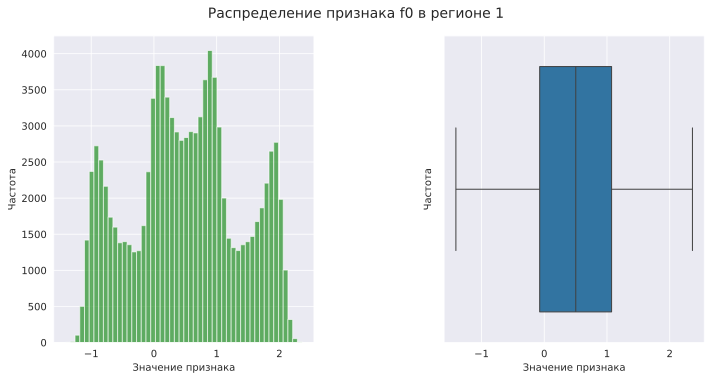

In [19]:
create_plots(data_1.f0, 'Значение признака', 'Частота', 'Распределение признака f0 в регионе 1')

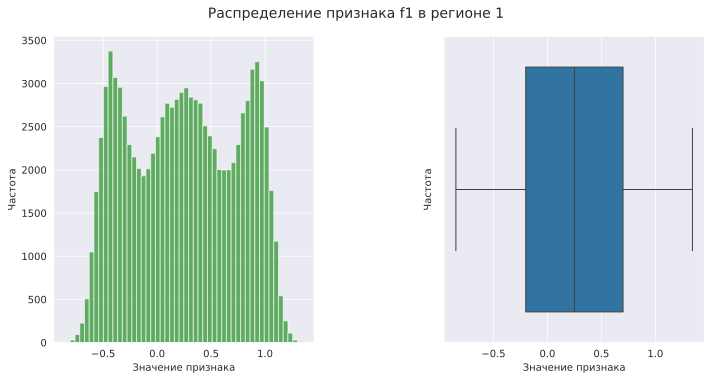

In [20]:
create_plots(data_1.f1, 'Значение признака', 'Частота', 'Распределение признака f1 в регионе 1')

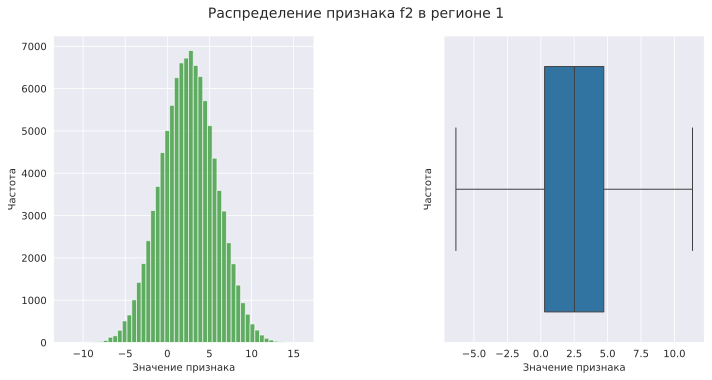

In [21]:
create_plots(data_1.f2, 'Значение признака', 'Частота', 'Распределение признака f2 в регионе 1')

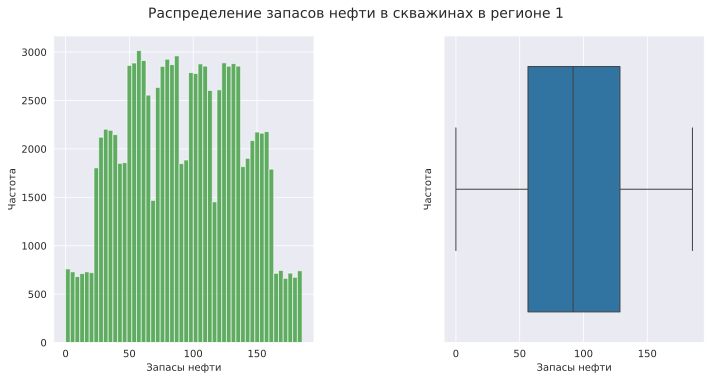

In [22]:
create_plots(data_1['product'], 'Запасы нефти', 'Частота', 'Распределение запасов нефти в скважинах в регионе 1')

In [23]:
geo_data_1 = data_1.set_index('id').copy()

In [24]:
сorr_matrix_geo_data_1 = geo_data_1.phik_matrix(interval_cols= ['f0', 'f1', 'f2', 'product'], bins = 5)
display(сorr_matrix_geo_data_1)

,f0,f1,f2,product
f0,1.000000,0.744632,0.001721,0.200682
f1,0.744632,1.000000,0.000000,0.270897
f2,0.001721,0.000000,1.000000,0.523476
product,0.200682,0.270897,0.523476,1.000000


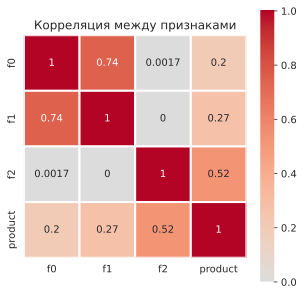

In [25]:
fig = plt.figure(figsize=(5, 5)) 
sns.heatmap(сorr_matrix_geo_data_1, annot = True, fmt = '.2g', cmap = 'coolwarm', vmin = 0, center = 0, linewidths = 2, square=True)
plt.title('Корреляция между признаками')
plt.show()

#### 1.2.2 датасет data_2

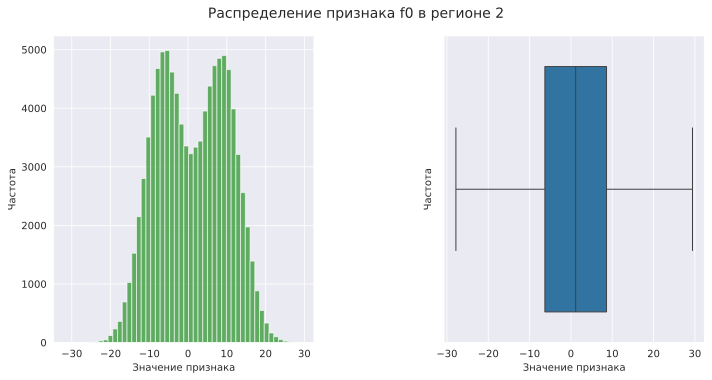

In [26]:
create_plots(data_2.f0, 'Значение признака', 'Частота', 'Распределение признака f0 в регионе 2')

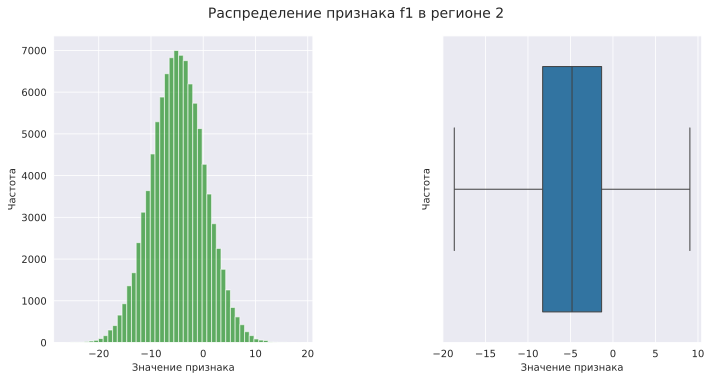

In [27]:
create_plots(data_2.f1, 'Значение признака', 'Частота', 'Распределение признака f1 в регионе 2')

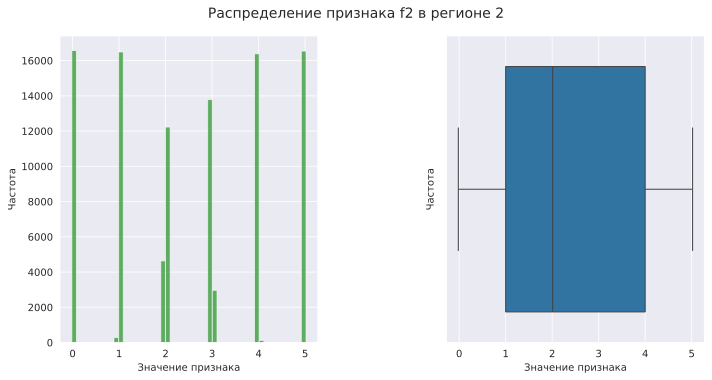

In [28]:
create_plots(data_2.f2, 'Значение признака', 'Частота', 'Распределение признака f2 в регионе 2')

In [29]:
data_2.f2.value_counts()

f2
-0.005876    1
 4.007133    1
 3.002704    1
 1.995378    1
 1.004327    1
            ..
 3.009891    1
 2.000013    1
 0.017600    1
 4.007500    1
-0.003299    1
Name: count, Length: 100000, dtype: int64

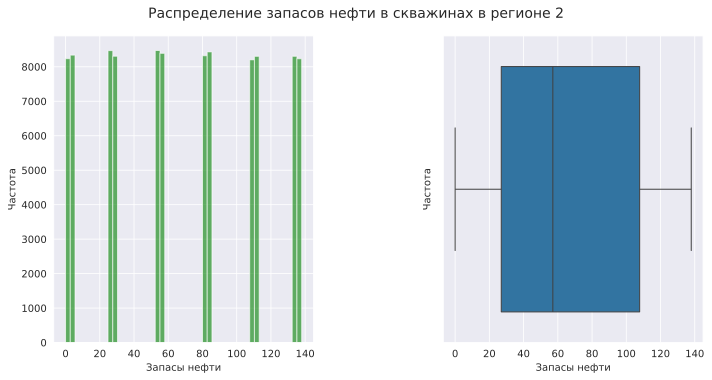

In [30]:
create_plots(data_2['product'], 'Запасы нефти', 'Частота', 'Распределение запасов нефти в скважинах в регионе 2')

In [31]:
data_2['product'].value_counts()

product
53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: count, dtype: int64

In [32]:
geo_data_2 = data_2.set_index('id').copy()

In [33]:
сorr_matrix_geo_data_2 = geo_data_2.phik_matrix(interval_cols= ['f0', 'f1', 'f2', 'product'], bins = 5)
display(сorr_matrix_geo_data_2)

,f0,f1,f2,product
f0,1.000000,0.209189,0.007087,0.248059
f1,0.209189,1.000000,0.000000,0.059987
f2,0.007087,0.000000,1.000000,0.945284
product,0.248059,0.059987,0.945284,1.000000


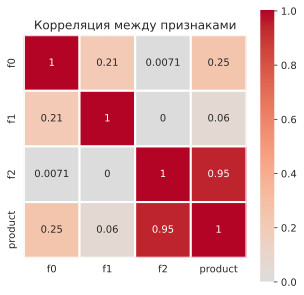

In [34]:
fig = plt.figure(figsize=(5, 5)) 
sns.heatmap(сorr_matrix_geo_data_2, annot = True, fmt = '.2g', cmap = 'coolwarm', vmin = 0, center = 0, linewidths = 2, square=True)
plt.title('Корреляция между признаками')
plt.show()

#### 1.2.2 датасет data_3

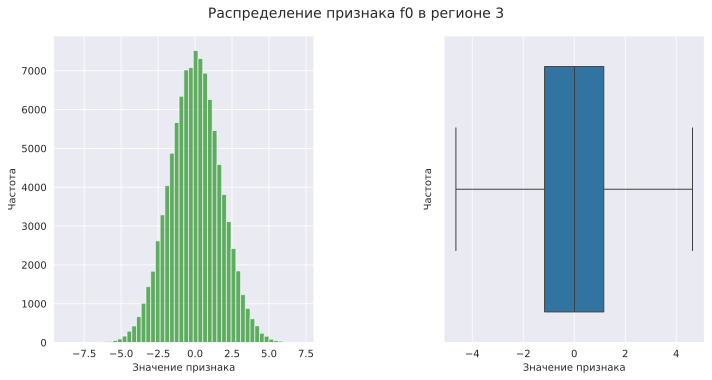

In [35]:
create_plots(data_3.f0, 'Значение признака', 'Частота', 'Распределение признака f0 в регионе 3')

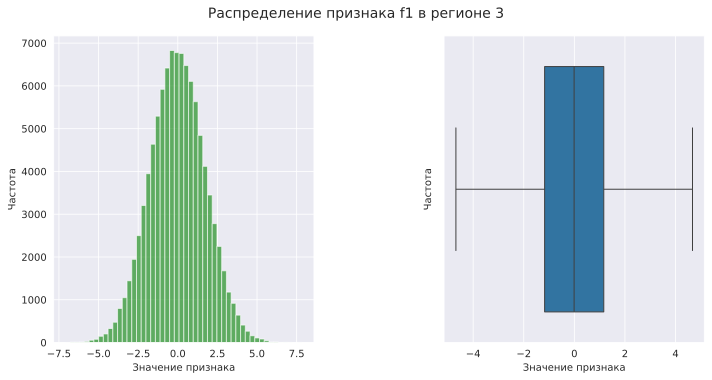

In [36]:
create_plots(data_3.f1, 'Значение признака', 'Частота', 'Распределение признака f1 в регионе 3')

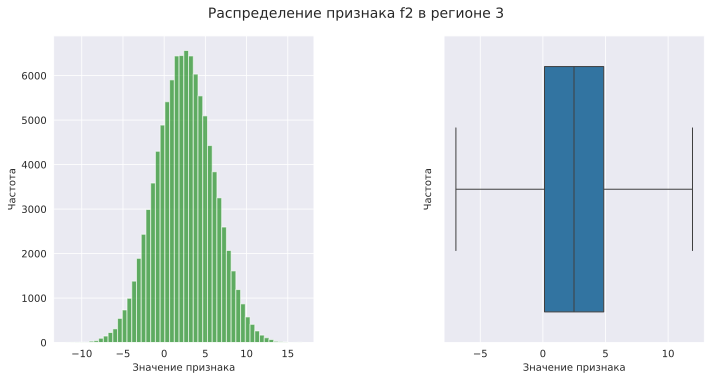

In [37]:
create_plots(data_3.f2, 'Значение признака', 'Частота', 'Распределение признака f2 в регионе 3')

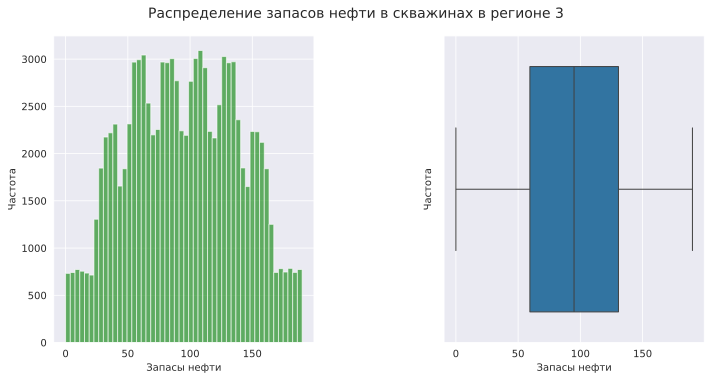

In [38]:
create_plots(data_3['product'], 'Запасы нефти', 'Частота', 'Распределение запасов нефти в скважинах в регионе 3')

In [39]:
geo_data_3 = data_3.set_index('id').copy()

In [40]:
сorr_matrix_geo_data_3 = geo_data_3.phik_matrix(interval_cols= ['f0', 'f1', 'f2', 'product'], bins = 5)
display(сorr_matrix_geo_data_3)

,f0,f1,f2,product
f0,1.000,0.000000,0.000000,0.196000
f1,0.000,1.000000,0.000000,0.245398
f2,0.000,0.000000,1.000000,0.491606
product,0.196,0.245398,0.491606,1.000000


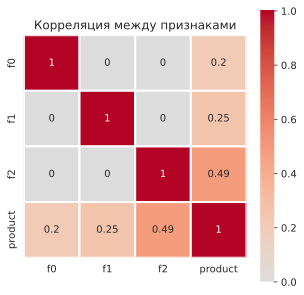

In [41]:
fig = plt.figure(figsize=(5, 5)) 
sns.heatmap(сorr_matrix_geo_data_3, annot = True, fmt = '.2g', 
            cmap = 'coolwarm', vmin = 0, center = 0, linewidths = 2, square=True)
plt.title('Корреляция между признаками')
plt.show()

In [42]:
data_1['dataset'] = 'Регион 1'
data_2['dataset'] = 'Регион 2'
data_3['dataset'] = 'Регион 3'

combined_df = pd.concat([data_1, data_2, data_3])

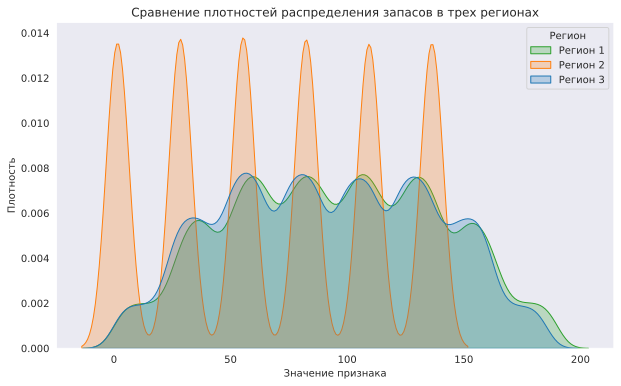

In [43]:
plt.figure(figsize=(10, 6))  # Устанавливаем размер графика

sns.kdeplot(data=combined_df, x='product', hue='dataset', common_norm=False, fill=True)

# Получаем список значений параметра dataset
datasets = combined_df['dataset'].unique()

plt.title('Сравнение плотностей распределения запасов в трех регионах')
plt.xlabel('Значение признака')
plt.ylabel('Плотность')
plt.legend(datasets, title='Регион')
plt.grid()
plt.show()

## 2. Разработка модели для каждого региона

In [44]:
names = ['geo_data_1', 'geo_data_2', 'geo_data_3']

In [45]:
# создадим словарь для хранения фактического и предсказанных значений набора test
targets = {}

# создадим функцию для инициализации модели и подбора гиперпараметров
def prediction(data, features, data_name, name):
    RANDOM_STATE = 42
    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        data[features],
        data['product'],
        test_size=0.25,
        random_state=RANDOM_STATE
    )

    # Преобразование признаков
    col_transformer = make_column_transformer((StandardScaler(), features))

    # Инициализация модели
    model = Ridge(random_state=RANDOM_STATE)
    pipeline = make_pipeline(col_transformer, model)
    
    # Параметры для поиска
    param_grid = {
        'ridge__alpha': np.arange(0, 0.3, 0.01)
    }
    
    # Поиск по сетке
    gd_search = GridSearchCV(
        pipeline, 
        param_grid, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    # Обучение модели
    gd_search.fit(X_train, y_train)

    # Предсказания
    y_pred = gd_search.predict(X_test)

    # Вычисление RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Преобразование предсказаний в Series
    y_pred_series = pd.Series(y_pred, index=y_test.index)

    # Сохранение фактических и предсказанных значений
    targets[name] = (y_test, y_pred_series)

    # Вывод информации
    print('Средний запас предсказанного сырья', data_name, round(y_pred.mean(), 2), 'тысяч баррелей')
    print('RMSE Ridge = ', round(rmse, 2))
    print('Лучшие параметры Ridge = ', gd_search.best_params_)

In [46]:
prediction(geo_data_1, ['f0', 'f1', 'f2'], data_name = 'в 1-ом регионе по данным geo_data_1:', name = 'geo_data_1')

Средний запас предсказанного сырья в 1-ом регионе по данным geo_data_1: 92.4 тысяч баррелей
RMSE Ridge =  37.76
Лучшие параметры Ridge =  {'ridge__alpha': 0.29}


In [47]:
prediction(geo_data_2, ['f0', 'f1', 'f2'], data_name = 'в 2-ом регионе по данным geo_data_2: ', name = 'geo_data_2')

Средний запас предсказанного сырья в 2-ом регионе по данным geo_data_2:  68.71 тысяч баррелей
RMSE Ridge =  0.89
Лучшие параметры Ridge =  {'ridge__alpha': 0.04}


In [48]:
prediction(geo_data_3, ['f0', 'f1', 'f2'], data_name = 'в 3-ем  регионе по данным geo_data_3 ', name = 'geo_data_3')

Средний запас предсказанного сырья в 3-ем  регионе по данным geo_data_3  94.77 тысяч баррелей
RMSE Ridge =  40.15
Лучшие параметры Ridge =  {'ridge__alpha': 0.29}


### Выводы по итогам обучения модели
Для предсказания была использована модель линейной регрессии с L2-регуляризацией.    
Данные, полученные по всем трем регионам, были разбиты на обучающую и тестовую выборки в соотношении 75% на 25%.    
Для каждого датасета использовались свои гиперпараметры, которые показали лучший результат при обучении.    
В результате предсказания получились следующие данные:
- регион 1: средний запас предсказанного сырья 92.4 тыс. баррелей, RMSE 37.76;
- регион 2: средний запас предсказанного сырья 68.71 тыс. баррелей, RMSE 0.89;
- регион 3: средний запас предсказанного сырья 94.77 тыс. баррелей, RMSE 40.15.
  Модель лучше всего себя показала на регионе 2, где RMSE составляет 0.89.

Если уберем признак f2 с высокой корреляцией из датасета geo_data_2, то получим следующие данные: средний запас предсказанного сырья во 2-ом регионе по данным geo_data_2: 68.85 тысяч баррелей, RMSE Ridge = 45.92, Лучшие параметры Ridge = {'ridge__alpha': 0.29}.
Запас сырья практически не отличается, но очень высокая ошибка RMSE на этих параметрах. 

## 3. Подготовка данных к расчету прибыли

In [49]:
TOTAL_WELL = 500 #количество исследуемых точек
BEST_WELL = 200 #отбор точек с помощью машинного обучения
PRICE = 450 # тыс. руб., доход от единицы продукции
BUDGET = 10000000 #  тыс. руб, бюджет на разработку скважин в регионе

In [50]:
# посчитаем, сколько необходимо добывать из каждой скважины, чтобы разработка окупилась
production_volume = BUDGET / BEST_WELL / PRICE 
print(f"Минимальный объем запасов для безубыточности: {production_volume :.2f}")

Минимальный объем запасов для безубыточности: 111.11


In [51]:
# Проверим, сколько скважин соответствуют объему безубыточности в каждом регионе.
count_well_1 = geo_data_1[geo_data_1['product'] > 111.11]
print(f"Количество скважин с запасами свыше 111.11 тыс. баррелей: {count_well_1['product'].count()}")
print(f"Доля от всех скважин в регионе 1: {count_well_1['product'].count() / 100000 * 100:.2f} %")
print(f"Разница со средним запасом в регионе 1: {92.4 - 111.11:.2f} тыс. баррелей")

Количество скважин с запасами свыше 111.11 тыс. баррелей: 36584
Доля от всех скважин в регионе 1: 36.58 %
Разница со средним запасом в регионе 1: -18.71 тыс. баррелей


In [52]:
count_well_2 = geo_data_2[geo_data_2['product'] > 111.11]
print(f"Количество скважин с запасами свыше 111.11 тыс. баррелей: {count_well_2['product'].count()}")
print(f"Доля от всех скважин в регионе 2: {count_well_2['product'].count() / 100000 * 100:.2f} %")
print(f"Разница со средним запасом в регионе 2: {68.71 - 111.11:.2f} тыс. баррелей")

Количество скважин с запасами свыше 111.11 тыс. баррелей: 16537
Доля от всех скважин в регионе 2: 16.54 %
Разница со средним запасом в регионе 2: -42.40 тыс. баррелей


In [53]:
count_well_3 = geo_data_3[geo_data_3['product'] > 111.11]
print(f"Количество скважин с запасами свыше 111.11 тыс. баррелей: {count_well_3['product'].count()}")
print(f"Доля от всех скважин в регионе 3: {count_well_3['product'].count() / 100000 * 100:.2f} %")
print(f"Разница со средним запасом в регионе 2: {94.77- 111.11:.2f} тыс. баррелей")

Количество скважин с запасами свыше 111.11 тыс. баррелей: 38178
Доля от всех скважин в регионе 3: 38.18 %
Разница со средним запасом в регионе 2: -16.34 тыс. баррелей


### Вывод по этапу подготовки данных к расчету прибыли
В рамках этапа был рассчитан минимальный запас нефти в скважине, чтобы окупить вложения в ее разработку, он составил 111,11 тысяч баррелей нефти. 
Были получены расчеты для каждого региона:
- в первом регионе таких скважин 36 854 (36,58% от всех скважин региона), средний объем запасов 92.4 тыс. баррелей, разница со средним запасом - 18.71 тыс. баррелей;
- во втором регионе 16 537 (16,54% от всех скважин региона), средний объем запасов 68.85 тыс. баррелей, разница со средним запасом - 42.4 тыс. баррелей;
- в третьем регионе 38 178 (38,18% от всех скважин региона), средний объем запасов 94.77 тыс. баррелей, разница со средним запасом - 16.34 тыс. баррелей. 
При разведке региона исследуют 500 точек, из которых выбирают 200 с помощью машинного обучения (40%). Пока наиболее подходящим кажется регион номер 3, так как у него самое высокое количество скважин, соответствующих минимальным запасам для безубыточности. При этом в данном регионе самая минимальная разница среднего объема запаса в скважинах с минимальным запасом нефти для окупаемости. 

## 4. Подсчет рисков и прибыли для каждого региона

In [54]:
# подготовим функцию для расчета прибыли
def revenue(targets, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = targets[probs_sorted.index][:count]
    profit = selected.sum() * PRICE 
    return profit - BUDGET 

In [55]:
state = np.random.RandomState(12345)
for name in names:
    values = []
    
    for _ in range(1000):
        target_subsample = targets[name][0].sample( n=TOTAL_WELL, replace=True, random_state=state)
        probs_subsample = targets[name][1][target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, BEST_WELL))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()

    risk = values.apply(lambda x: x < 0).sum() / 1000
    
    print(f'Для региона по данным {name}:')
    print(f'Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} тыс. рублей.')
    print(f'Доверительный интервал распределения прибыли находится в пределах от {lower:.0f} до {upper:.0f} тыс. рублей.')
    print(f'Расчетная вероятность убытков составляет = {risk:.2%}')
    print()

Для региона по данным geo_data_1:
Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 435934 тыс. рублей.
Доверительный интервал распределения прибыли находится в пределах от -116232 до 966504 тыс. рублей.
Расчетная вероятность убытков составляет = 6.10%

Для региона по данным geo_data_2:
Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 498569 тыс. рублей.
Доверительный интервал распределения прибыли находится в пределах от 75316 до 911504 тыс. рублей.
Расчетная вероятность убытков составляет = 1.00%

Для региона по данным geo_data_3:
Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 412673 тыс. рублей.
Доверительный интервал распределения прибыли находится в пределах от -158940 до 978191 тыс. рублей.
Расчетная вероятность убытков составляет = 7.00%



### Выводы по этапу подсчета рисков и прибыли

В рамках данного этапа была написана функция, которая позволила выбрать 200 скважин с максимальными количествами предсказаний, было просуммировано целевое значение объёма сырья, соответствующее этим предсказаниям, и рассчитана прибыль для полученного объема сырья по регионам.
Была применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
Была найдена средняя прибыль, 95%-й доверительный интервал и риск убытков.
* Для региона 1:
    - Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 435934 тыс. рублей.
    - Доверительный интервал распределения прибыли находится между -116232 / 966504 тыс. рублей.
    - Риск убытков составляет = 6.10%
* Для региона по данным 2:
    - Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 498569 тыс. рублей.
    - Доверительный интервал распределения прибыли находится между 75316 / 911504 тыс. рублей.
    - Риск убытков составляет = 1.00%
* Для региона по данным 3:
    - Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 412673 тыс. рублей.
    - Доверительный интервал распределения прибыли находится между -158940 / 978191 тыс. рублей.
    - Риск убытков составляет = 7.00%

## Итоги по проведенному исследованию

1. Было получено три датасета:
* data_1, пропуски отсутствуют, тип данных корректный, явных дубликатов нет;
* data_2, пропуски отсутствуют, тип данных корректный, явных дубликатов нет;
* data_3, пропуски отсутствуют, тип данных корректный, явных дубликатов нет.
  Данных достаточно для анализа, все три датасета содержат одинаковое количество наблюдений.
В каждом датасете проверено распределение данных и выбросы. В данных есть незначительное количество выбросов, но так как природа их не ясна, принято решение их оставить.

Обратили внимание, что распределение данных по региону 2 заметно отличается от двух других регионов, данные распределены неравномерно, это можно объяснить иным способом сбора данных для модели (например, фиксация среднего значения при попадании данных в диапазон).
При сравнении плотности распределения запасов нефти в каждом регионе видно большое количество скважин в регионе 2 с похожими значениями.

2. Для предсказания была использована модель линейной регрессии с L2-регуляризацией.    
Данные, полученные по всем трем регионам, были разбиты на обучающую и тестовую выборки в соотношении 75% на 25%.    
Для каждого датасета использовались свои гиперпараметры, которые показали лучший результат при обучении.    
В результате предсказания получились следующие данные:
- регион 1: средний запас предсказанного сырья 92.4 тыс. баррелей, RMSE 37.76;
- регион 2: средний запас предсказанного сырья 68.71 тыс. баррелей, RMSE 0.89;
- регион 3: средний запас предсказанного сырья 94.77 тыс. баррелей, RMSE 40.15.
  Модель лучше всего себя показала на регионе 2, где RMSE составляет 0.89.

3. В рамках этапа был рассчитан минимальный запас нефти в скважине, чтобы окупить вложения в ее разработку, он составил 111,11 тысяч баррелей нефти. 
Были получены расчеты для каждого региона:
- в первом регионе таких скважин 36 854 (36,58% от всех скважин региона), средний объем запасов 92.4 тыс. баррелей, разница со средним запасом - 18.71 тыс. баррелей;
- во втором регионе 16 537 (16,54% от всех скважин региона), средний объем запасов 68.85 тыс. баррелей, разница со средним запасом - 42.4 тыс. баррелей;
- в третьем регионе 38 178 (38,18% от всех скважин региона), средний объем запасов 94.77 тыс. баррелей, разница со средним запасом - 16.34 тыс. баррелей. 
В регионе 3 самая минимальная разница среднего объема запаса в скважинах с минимальным запасом нефти для окупаемости. 

4. Была написана функция, которая позволила выбрать 200 скважин с максимальными количествами предсказаний, было просуммировано целевое значение объёма сырья, соответствующее этим предсказаниям, и рассчитана прибыль для полученного объема сырья по регионам.
Была применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
Была найдена средняя прибыль, 95%-й доверительный интервал и риск убытков.
* Для региона 1:
    - Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 435934 тыс. рублей.
    - Доверительный интервал распределения прибыли находится между -116232 / 966504 тыс. рублей.
    - Риск убытков составляет = 6.10%
* Для региона по данным 2:
    - Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 498569 тыс. рублей.
    - Доверительный интервал распределения прибыли находится между 75316 / 911504 тыс. рублей.
    - Риск убытков составляет = 1.00%
* Для региона по данным 3:
    - Средняя прибыль с 200 лучших скважин, отобраных по предсказанию = 412673 тыс. рублей.
    - Доверительный интервал распределения прибыли находится между -158940 / 978191 тыс. рублей.
    - Риск убытков составляет = 7.00%
 
Исходя из полученных задач, наиболее привлекательным для разработки считается регион 2, так как только в нем риск убытков составляет 1%, что и требовал заказчик, а также этот регион показывает самую высокую среднюю прибыль по 200 отобранным скважинам.    
Но если бы изначально не было озвучено, что данные синтетические, то стала бы смотреть, что при построении модели признак f2 показывал очень высокую корреляцию с целевым признаком, и есть шанс, что модель переучилась,  я бы рекомендовала провести повторное исследование по данному региону с учетом дополнительных признаков (при расчете риска убытков по региону 2 с прогнозами, построенными без признака f2, риск убытков составил 100%). Также необходимо было бы пересмотреть сбор данных по признаку f2 и product при возможном повторном исследовании, так как в настоящий момент распределение значений значительно отличается от значений по другим регионам (в данных есть несколько значений, которые встречаются очень часто, при этом часть значений отсутствует). И возможно предложила бы заказчику рассмотреть вариант разработки скважин в регионе 1, где средняя прибыль чуть ниже, чем по региону 2, но качество данных не вызывает дополнительных вопросов.